In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit

experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
#################################################
h_layer = 8
beta = 0.4
interpolation_steps = 100
#################################################

In [5]:
def save_order_1_approx(approx, file_name = "order_1_approx", path = "../results/interpolation"):
    os.makedirs(path, exist_ok=True)
    detached = {}
    for k,v in approx.__dict__.items():
        if isinstance(v, torch.Tensor):
            detached[k] = v.detach().cpu().numpy()
        else:
            detached[k] = v
    np.savez(f"{path}/{file_name}.npz", **detached)

In [6]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-21 12:07:03 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [7]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(5)

In [8]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> Pakistan: Islamabad
 Argentina: Buenos Aires
 Peru: Lima
 Australia: Canberra
 Germany: Berlin
 {}:


In [9]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

18

In [10]:
s1, s2 = "Russia", "France"

functional.predict_next_token(
    mt = mt,
    prompt=[icl_prompt.format(s1), icl_prompt.format(s2)],
)

[[PredictedToken(token=' Moscow', prob=0.9652737379074097),
  PredictedToken(token=' St', prob=0.014887720346450806),
  PredictedToken(token=' Saint', prob=0.005065291654318571),
  PredictedToken(token=' Vlad', prob=0.0012316431384533644),
  PredictedToken(token=' Sochi', prob=0.0009517401922494173)],
 [PredictedToken(token=' Paris', prob=0.9264856576919556),
  PredictedToken(token=' Lyon', prob=0.013742058537900448),
  PredictedToken(token=' Stras', prob=0.009082946926355362),
  PredictedToken(token=' T', prob=0.005595840513706207),
  PredictedToken(token=' B', prob=0.0033940488938242197)]]

In [12]:
hs_and_zs = functional.compute_hs_and_zs(
    mt = mt,
    prompt_template = train.prompt_templates[0],
    subjects = list(set([sample.subject for sample in relation.samples] + [s1, s2])),
    h_layer= h_layer,
    z_layer=-1,
    examples= train.samples
)
h1, h2 = [hs_and_zs.h_by_subj[s] for s in [s1, s2]]

In [13]:
torch.dist(h1, h2)

tensor(51.2812, device='cuda:0', dtype=torch.float16)

In [25]:
H = []
for alpha in np.linspace(0, 1, interpolation_steps):
    H.append(h1 * (1-alpha) + h2 * alpha)
H = torch.stack(H)
torch.dist(h1, H[-1])

tensor(51.2812, device='cuda:0', dtype=torch.float16)

In [26]:
h_index, inputs = functional.find_subject_token_index(
    mt=mt, prompt=icl_prompt.format(s1), subject=s1
)

In [185]:
for idx, h in tqdm(enumerate(H)):
    approx = functional.order_1_approx(
        mt = mt,
        prompt = icl_prompt.format(s1),
        h_layer = h_layer,
        h_index= h_index,
        h = h
    )
    save_order_1_approx(approx, file_name = f"approx_{idx+1}")
    w_norm = approx.weight.norm()
    b_norm = approx.bias.norm()
    jh_norm = approx.metadata['Jh'].norm()
    top_predictions, _ = lens.logit_lens(mt, approx.z, get_proba=True, k=3)
    print(f"{idx+1} => {w_norm=:.2f} | {b_norm=:.2f} | {jh_norm=:.2f} | {top_predictions=}")

0it [00:00, ?it/s]

1 => w_norm=28.05 | b_norm=250.38 | jh_norm=21.50 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.011), (' St', 0.011)]
2 => w_norm=28.16 | b_norm=250.50 | jh_norm=21.52 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.011), (' St', 0.011)]
3 => w_norm=28.25 | b_norm=250.38 | jh_norm=21.53 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.011), (' St', 0.011)]
4 => w_norm=28.34 | b_norm=250.50 | jh_norm=21.53 | top_predictions=[(' Moscow', 0.949), (' Saint', 0.011), (' St', 0.011)]
5 => w_norm=28.45 | b_norm=250.50 | jh_norm=21.56 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.011), (' St', 0.011)]
6 => w_norm=28.56 | b_norm=250.50 | jh_norm=21.58 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.011), (' St', 0.011)]
7 => w_norm=28.69 | b_norm=250.50 | jh_norm=21.61 | top_predictions=[(' Moscow', 0.948), (' Saint', 0.012), (' St', 0.011)]
8 => w_norm=28.80 | b_norm=250.38 | jh_norm=21.66 | top_predictions=[(' Moscow', 0.947), (' Saint', 0.012), (' St', 0.011)]
9 => w_n

In [14]:
path = "../results/interpolation"
W_norms = []
B_norms = []
Jh_norms = []
J_delta_h = []
labels = []

for trial in os.listdir(path):
    print(trial)
    trial_path = os.path.join(path, trial)
    approxes = []
    for idx in tqdm(range(interpolation_steps)):
        approx = np.load(f"{trial_path}/approx_{idx+1}.npz", allow_pickle=True)
        approx_dict = {}
        for k,v in approx.items():
            if k in ["h", "z", "weight", "bias"]:
                approx_dict[k] = torch.from_numpy(v).cuda()
            else:
                approx_dict[k] = v
        approxes.append(approx_dict)

    w_norms = [torch.Tensor(a['weight']).norm().item() for a in approxes]
    b_norms = [torch.Tensor(a['bias']).norm().item() for a in approxes]
    jh_norms = [torch.Tensor(a["metadata"].item()["Jh"]).norm().item() for a in approxes]

    h1 = approxes[0]['h']
    h2 = approxes[-1]['h']
    # delta_h = (h1 + h2)/2
    delta_h = hs_and_zs.h_by_subj["Russia"]
    j_delta_h = [(torch.Tensor(a['weight']) @ delta_h).norm().item() for a in approxes]

    W_norms.append(w_norms)
    B_norms.append(b_norms)
    Jh_norms.append(jh_norms)
    J_delta_h.append(j_delta_h)
    labels.append(trial)

Nigeria-France


  0%|          | 0/100 [00:00<?, ?it/s]

France-Egypt


  0%|          | 0/100 [00:00<?, ?it/s]

South Korea-Brazil


  0%|          | 0/100 [00:00<?, ?it/s]

France-Italy


  0%|          | 0/100 [00:00<?, ?it/s]

Brazil-Nigeria


  0%|          | 0/100 [00:00<?, ?it/s]

Egypt-China


  0%|          | 0/100 [00:00<?, ?it/s]

Venezuela-Nigeria


  0%|          | 0/100 [00:00<?, ?it/s]

Egypt-South Korea


  0%|          | 0/100 [00:00<?, ?it/s]

France-Spain


  0%|          | 0/100 [00:00<?, ?it/s]

Chile-Egypt


  0%|          | 0/100 [00:00<?, ?it/s]

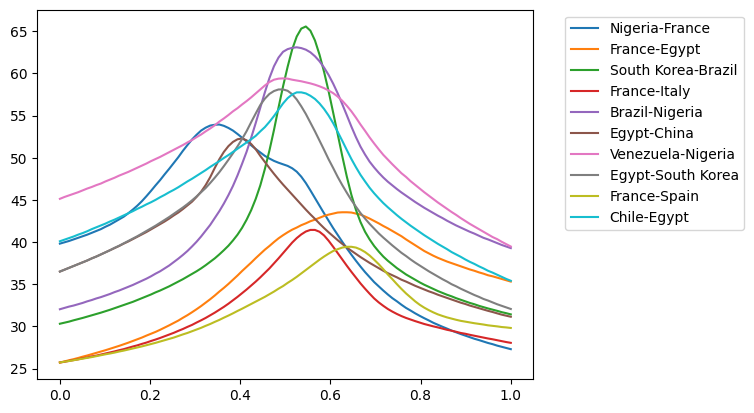

In [20]:
for trial, label in zip(W_norms, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0, 0.5, 'Jh_norm')

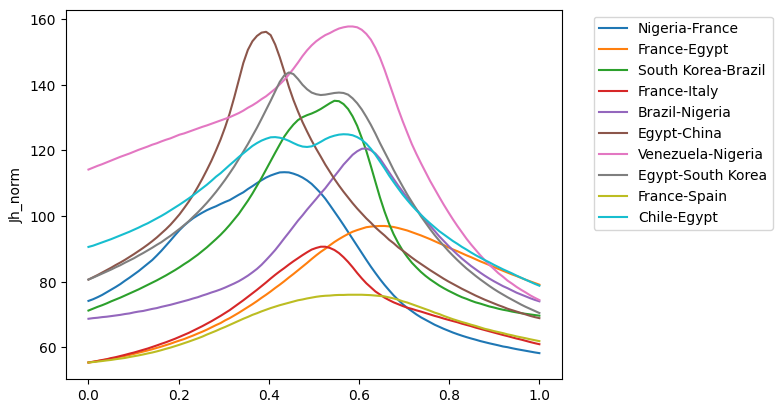

In [21]:
# J(h2 - h1)
for trial, label in zip(J_delta_h, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Jh_norm")

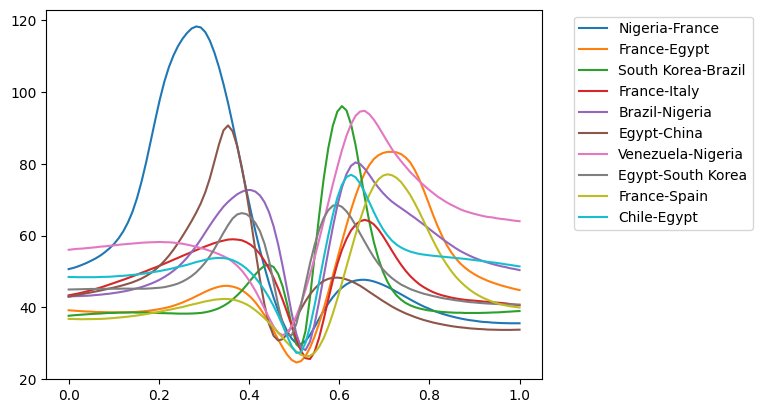

In [36]:
# J @ (h1 + h2)/2
for trial, label in zip(J_delta_h, labels):
    plt.plot(np.linspace(0, 1, interpolation_steps), trial, label=label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

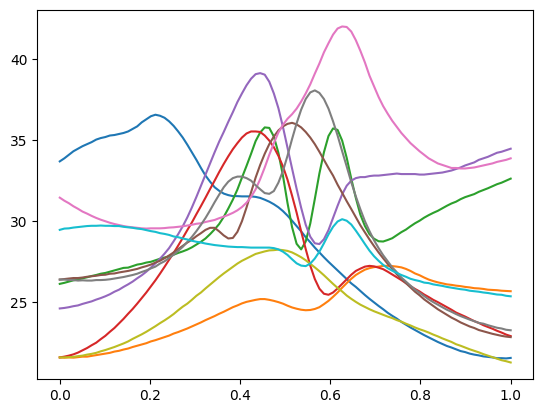

In [32]:
for trial in Jh_norms:
    plt.plot(np.linspace(0, 1, interpolation_steps), trial)

## Certain concepts are underestimated?

In [27]:
ln_f = baukit.get_module(mt.model, "transformer.ln_f")

In [28]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=7, beta=0.2
)
operator = estimator(train)

In [29]:
hs_and_zs.h_by_subj.keys()

dict_keys(['Venezuela', 'Egypt', 'Argentina', 'Peru', 'Nigeria', 'Saudi Arabia', 'United States', 'China', 'Pakistan', 'Spain', 'Canada', 'Japan', 'Mexico', 'India', 'Turkey', 'Russia', 'Australia', 'Colombia', 'Italy', 'Brazil', 'South Korea', 'Chile', 'Germany', 'France'])

In [69]:
subject = "Spain"
h = hs_and_zs.h_by_subj[subject]
expected = hs_and_zs.z_by_subj[subject]
lens.logit_lens(mt, expected, get_proba=True)

([(' Madrid', 0.824),
  (' Barcelona', 0.112),
  (' Se', 0.006),
  (' Valencia', 0.004),
  (' Bil', 0.003),
  (' Sev', 0.003),
  (' Spain', 0.002),
  (' London', 0.002),
  (' Pal', 0.002),
  (' ', 0.002)],
 {})

In [70]:
estimated_mean = (operator.weight @ h + operator.bias).squeeze()
print(expected.norm().item(), estimated_mean.norm().item())
print(torch.dist(expected, estimated_mean).item())
lens.logit_lens(mt, estimated_mean, get_proba=True)

255.625 267.5
107.4375


([(' Madrid', 0.196),
  (' ', 0.073),
  ('\n', 0.05),
  (' Buenos', 0.048),
  (' New', 0.041),
  (' C', 0.035),
  (' London', 0.028),
  (' Santiago', 0.025),
  (' Paris', 0.023),
  (' Berlin', 0.018)],
 {})

In [71]:
lm_head = mt.lm_head
expected_logits = lm_head(expected)
estimated_logits = lm_head(estimated_mean)

estimation_errors = (expected_logits - estimated_logits)

In [72]:
underestimations = estimation_errors.topk(10, largest=True)
[(t.item(), mt.tokenizer.decode(t)) for t in underestimations.indices]

[(46929, ' Vall'),
 (37918, ' Sev'),
 (46941, ' Ov'),
 (43248, ' Bale'),
 (35773, ' Valencia'),
 (10272, ' Jere'),
 (33859, ' Catalonia'),
 (28193, ' Zar'),
 (18454, 'Mad'),
 (24207, ' Bil')]

In [73]:
overestimations = estimation_errors.topk(10, largest=False)
[(t.item(), mt.tokenizer.decode(t)) for t in overestimations.indices]

[(46154, ' Karachi'),
 (41649, ' DAR'),
 (35893, ' Wah'),
 (16991, 'Islam'),
 (36878, ' Islamabad'),
 (39654, ' Pesh'),
 (30693, ' Lah'),
 (16089, ' Raw'),
 (41154, ' Clover'),
 (456, 'gh')]